In [18]:
from Genome.pangenome_annotate.gold_anno_downstream import *
from ddot import Ontology
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
%matplotlib inline
root_dir = '/home/hermuba/data0118/fig/'

# our ontology
ont2 = Ontology.from_table('/home/hermuba/data0118/network1122/candidate_ontologies')
# align to aro
align_aro = pd.read_csv('~/data0118/network1122/candidate_ontologies_term_anno.csv', header = 0, index_col = 0)
align_aro.set_index('index', inplace = True)

# load original gene annotation
gold_anno = pd.read_pickle('/home/hermuba/data0118/goldstandard/ec_rmplasmid_node_anno_df')

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)


In [2]:
align_aro.loc['S:791']

Term                                                 ARO:3002704
Similarity                                              0.663034
FDR                                                            0
Accession                                            ARO:3002704
Name                                                        fexA
Description    fexA is a plasmid-encoded chloramphenicol expo...
Name: S:791, dtype: object

In [3]:
# extract branch
s787_br = ont2.focus(branches = 'S:791')

# extract annotations
s787_genes = gold_anno.loc[s787_br.genes]

Genes and Terms to keep: 149


/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)


In [4]:
s787_genes.shape

(132, 20)

In [5]:
# explore annotation status, existing annotation is quite rare
s787_genes[['cog_ID', 'strict_best_ARO', 'resfam']].count()

cog_ID             121
strict_best_ARO     10
resfam             116
dtype: int64

In [6]:
popular_cogs = count_cog(s787_genes)

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


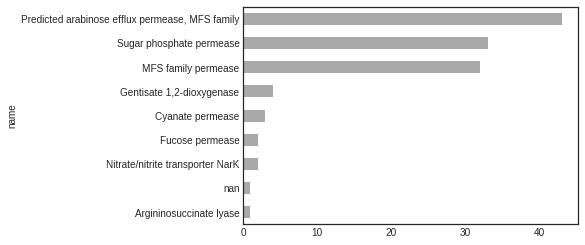

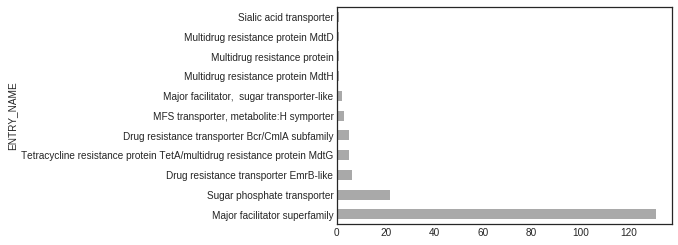

In [25]:

domain.loc[domain['ENTRY_TYPE'] == 'Family'].set_index('ENTRY_NAME')['no_genes'].plot(kind = 'barh', color = 'darkgray')

In [8]:
domain = count_domain(s787_genes)
domain.loc[(domain['ENTRY_NAME'].str.contains('HTH'))|(domain['ENTRY_NAME'].str.contains('DNA'))|(domain['ENTRY_NAME'].str.contains('LysR')), 'category'] = 'regulator'
domain.loc[(domain['ENTRY_NAME'].str.contains('HTH'))|(domain['ENTRY_NAME'].str.contains('DNA'))|(domain['ENTRY_NAME'].str.contains('LysR')), 'category'] = 'regulator'

In [10]:
regulator_domain = set(domain.loc[domain['category'] == 'regulator'].index)
s787_genes.loc[~s787_genes['domain'].map(lambda x: x.isdisjoint(regulator_domain))]

,cog_ID,cog_category,cluster,count,core,loose_best_ARO,loose_ARO,strict_best_ARO,strict_ARO,is_card,resfam,aclame_title,is_aclame,nr,hypo_nr,drug_target,is_drug_target,GO,pathway,domain
562.23885.con.0001_10|562.23885,COG2814,G,Cluster 3374,1576.0,True,cmlv,"ARO:3002702, ARO:3002704, ARO:3002693, ARO:300...",NaN,NaN,False,"{Chlor_Efflux_Pump, emrB, MFS_efflux}",protein:plasmid:15723 Length: 285 # NCBI annot...,True,WP_044191923.1 sugar efflux transporter [Esche...,NaN,NaN,False,"{GO:0055085, GO:0003700, GO:0006355, GO:0016021}",NaN,"{IPR020846, IPR036259, IPR000847, IPR036388, I..."


In [12]:
import numpy as np
import igraph

def map_annotation_to_igraph(igraph_obj, align_aro, new_res_genes, root, node_lbl = 'aro', node_color = 'hypo_nr'):
    ''' to map annotation to igraph object for the purpose of visualization
    '''
    keys = igraph_obj.vs['name'] # id are stored in here
    # weird .0 is added
    keys = [i[:-(len(i.split('.')[-1])+1)] for i in keys]
    
    igraph_obj.vs['size'] = [12 if 'S:' in i else 10 for i in keys]
    igraph_obj.vs['label_size'] = [12 if 'S:' in i else 6 for i in keys]
    
    # resfam annotation(gene)
    igraph_obj.vs['resfam'] = [new_res_genes.loc[i, 'resfam'] if i in new_res_genes.index else '' for i in keys]
    # aro annotation (gene use name, term use align aro)
    igraph_obj.vs['aro'] = [new_res_genes.loc[i, 'strict_best_ARO'] if i in new_res_genes.index else align_aro.loc[i, 'Name'] if i in align_aro.index else '' for i in keys]
    # nr annotation
    igraph_obj.vs['nr'] = [new_res_genes.loc[i, 'nr'] if i in new_res_genes.index else '' for i in keys]
    # hypothetical or not
    igraph_obj.vs['hypo'] = [new_res_genes.loc[i, 'hypo_nr'] if i in new_res_genes.index else '' for i in keys]
    # category
    igraph_obj.vs['cog'] = [new_res_genes.loc[i, 'cog_ID'] if i in new_res_genes.index else '' for i in keys]
    
    
    
    # decide label
    if node_lbl == 'aro':
        igraph_obj.vs['label'] = [new_res_genes.loc[i, 'strict_best_ARO'] if i in new_res_genes.index else align_aro.loc[i, 'Name'] if i in align_aro.index else '' for i in keys]
    else:
        igraph_obj.vs['label'] = [new_res_genes.loc[i, 'resfam'] if i in new_res_genes.index else align_aro.loc[i, 'Name'] if i in align_aro.index else '' for i in keys]
    igraph_obj.vs['label'] = [i if type(i)==str else '' for i in igraph_obj.vs['label']]
    
    # color
    color_list = []
    
    for i in keys:
        if 'S:' in i:
            if i == root:
                color_list.append('red')
            else:
                color_list.append('grey')
                
        elif node_color == 'hypo_nr':
            if new_res_genes.loc[i, node_color] == True:
                color_list.append('blue')
            else:
                color_list.append('pink')
        elif node_color == 'category':
            if new_res_genes.loc[i, node_color] == 'Regulator':
                color_list.append('purple')
            elif new_res_genes.loc[i, node_color] == 'Sensor':
                color_list.append('yellow')
            else:
                color_list.append('pink')
        #elif node_color == 'domain':
        #   if new_res_genes.
    igraph_obj.vs['color'] = color_list
    return(igraph_obj)

In [13]:
s787 = ont2.focus(branches = 'S:791').unfold().to_igraph()

Genes and Terms to keep: 149


/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)


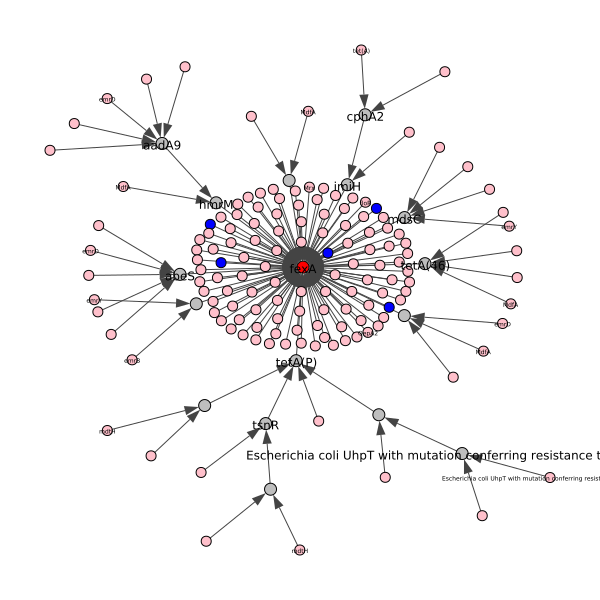

In [14]:

from igraph import *
s787 = map_annotation_to_igraph(s787, align_aro, s787_genes, 'S:791', node_lbl = 'aro', node_color = 'hypo_nr')
layout = s787.layout("kk")
plot(s787, "s791_aro.pdf", layout = layout, margin = 50)



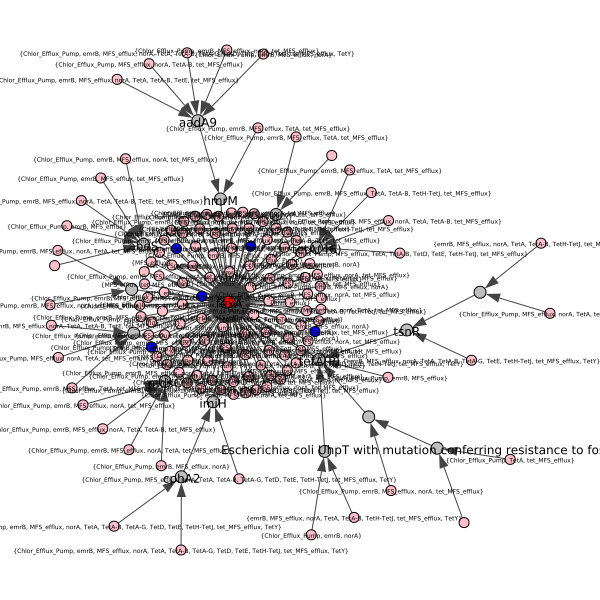

In [15]:

from igraph import *
s787 = map_annotation_to_igraph(s787, align_aro, gold_anno, 'S:791', node_lbl = 'resfam', node_color = 'hypo_nr')
layout = s787.layout("kk")
plot(s787, "s791_aro.pdf", layout = layout, margin = 50)



In [16]:
all_resfam = set()
_ = [all_resfam.update(set(i[1:-1].split(', '))) for i in s787_genes['resfam'] if type(i)!= float]
all_resfam.update(set(['Chloramphenicol_Efflux_Pump', 'MFSAntibioticEffluxPump', 'Tetracycline_Resistance_MFS_Efflux_Pump','RNDAntibioticEffluxPump'])) # seem to have older versions of name in metadata
resfam_metadata = pd.read_excel('/nas/hermuba/180102_resfams_metadata_updated_v122.xlsx', header = 3)
resfam_metadata = resfam_metadata.loc[resfam_metadata['Resfam Family Name'].isin(all_resfam)]
resfam_metadata.set_index('Resfam Family Name', inplace = True)
resfam_metadata = resfam_metadata[['ResfamID', 'Description', 'CARD_ARO_Updated', 'Mechanism Classification']]
resfam_metadata.index = ['Chlor_Efflux_Pump' if 'Chlor' in i else 'MFS_efflux' if 'MFSA' in i else 'tet_MFS_efflux' if 'Tetracycline' in i else 'RND_efflux' if 'RND' in i else i for i in resfam_metadata.index]
resfam_metadata['count'] = 0
for i in s787_genes['resfam']:
    if type(i) != float:
        family = i[1:-1].split(', ')
        
        resfam_metadata.loc[family, 'count'] = resfam_metadata.loc[family, 'count'] + 1

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


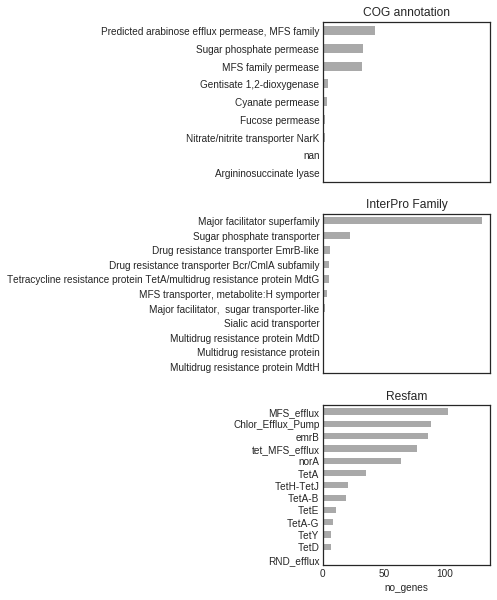

In [32]:
f,ax = plt.subplots(3,1, figsize = (3,10), sharex = True)
popular_cogs.sort_values('no_genes').set_index('name')['no_genes'].plot(kind = 'barh', color = 'darkgray', ax = ax[0], title = 'COG annotation')
domain.loc[domain['ENTRY_TYPE'] == 'Family'].sort_values('no_genes').set_index('ENTRY_NAME')['no_genes'].plot(kind = 'barh', color = 'darkgray', ax = ax[1], title = 'InterPro Family')

resfam_metadata.sort_values('count')['count'].plot(kind = 'barh', title = 'Resfam', color = 'darkgray', ax = ax[2])
_ = [ax[i].set_ylabel('') for i in range(2)]
ax[2].set_xlabel('no_genes')
plt.tight_layout()
plt.savefig(root_dir+'s791_all_bar.pdf', dpi = 300)